In [ ]:
!git clone https://github.com/kishorsabarishg/l5kit.git

Cloning into 'l5kit'...
remote: Enumerating objects: 11247, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 11247 (delta 143), reused 191 (delta 137), pack-reused 11047
Receiving objects: 100% (11247/11247), 102.56 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (8305/8305), done.


In [ ]:
!git clone https://github.com/woven-planet/l5kit.git

Cloning into 'l5kit'...
remote: Enumerating objects: 11226, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 11226 (delta 130), reused 173 (delta 129), pack-reused 11047
Receiving objects: 100% (11226/11226), 102.56 MiB | 27.03 MiB/s, done.
Resolving deltas: 100% (8294/8294), done.


In [ ]:
%cd l5kit/

/content/l5kit


In [ ]:
!ls

dataset_metadata  docs	examples  l5kit  README.md  scripts


In [ ]:
%cd examples/

/content/l5kit/examples


In [ ]:
!ls

agent_motion_prediction  planning  setup_notebook_colab.sh  urban_driver
drivergym		 RL	   simulation		    visualisation


In [ ]:
!sh ./setup_notebook_colab.sh

sample.tar          100%[===================>]  51.37M  16.1MB/s    in 3.8s    
semantic_map.tar    100%[===================>]   2.86M  2.57MB/s    in 1.1s    
aerial_map.tar      100%[===================>]   2.28G  18.4MB/s    in 2m 8s   
Installing L5kit...






  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Dataset and L5kit are ready !


In [ ]:
pip uninstall opencv-python-headless==4.5.5.62

In [ ]:
pip install opencv-python-headless==4.5.2.52

     |████████████████████████████████| 38.2 MB 1.3 MB/s 


In [ ]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

In [ ]:
os.getcwd()

'/content/l5kit/examples'

In [ ]:
%cd l5kit/

[Errno 2] No such file or directory: 'l5kit/'
/content/l5kit/examples


In [ ]:
%cd examples/

[Errno 2] No such file or directory: 'examples/'
/content/l5kit/examples


In [ ]:
os.environ["L5KIT_DATA_FOLDER"] = open("./dataset_dir.txt", "r").read().strip()

In [ ]:
# set env variable for data
# os.environ["L5KIT_DATA_FOLDER"] = "/home/kishorsabarishg/Desktop/AI4AV_project/"
# dm = LocalDataManager(None)
# get config
cfg = load_config_data("/content/l5kit/examples/agent_motion_prediction/agent_motion_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'train_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'key': 'val/validate.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}


In [ ]:
dm = LocalDataManager(None)

In [ ]:
cfg["val_data_loader"]

{'batch_size': 12,
 'key': 'scenes/sample.zarr',
 'num_workers': 16,
 'shuffle': False}

In [ ]:
def build_model(cfg: Dict) -> torch.nn.Module:
    # load pre-trained Conv2D model
    model = resnet50(pretrained=True)

    # change input channels number to match the rasterizer's output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # model.conv1 = nn.Conv2d(
    #     num_in_channels,
    #     model.conv1.out_channels,
    #     kernel_size=model.conv1.kernel_size,
    #     stride=model.conv1.stride,
    #     padding=model.conv1.padding,
    #     bias=False,
    # )
    # change output size to (X, Y) * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)

    return model

In [ ]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

In [ ]:
# ===== INIT DATASET
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
# train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
# train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
# train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
#                              num_workers=train_cfg["num_workers"])
# print(train_dataset)

In [ ]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

In [ ]:
log_dir = os.path.join(os.getcwd(), "logs", "run_" + timestr)
os.makedirs(log_dir)

In [ ]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = build_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="none")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# ==== TRAIN LOOP
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
for i,_ in enumerate(progress_bar):
    
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    loss, _ = forward(data, model, device, criterion)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
    if i%100 == 0:
        print("Saving Checkpoint",i)
        torch.save(model.state_dict(), os.path.join(log_dir, "checkpoint_epoch" + str(i) + ".pth"))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
loss: 143.0951690673828 loss(avg): 143.0951690673828:   0%|          | 0/6000 [00:10<?, ?it/s]

Saving Checkpoint 0


loss: 57.67143249511719 loss(avg): 61.73138482499831:   2%|▏         | 100/6000 [00:56<42:46,  2.30it/s]

Saving Checkpoint 100


loss: 42.06147003173828 loss(avg): 53.83817379510225:   3%|▎         | 200/6000 [01:32<29:53,  3.23it/s]

Saving Checkpoint 200


loss: 67.35417175292969 loss(avg): 51.76135763694282:   5%|▌         | 300/6000 [02:03<32:05,  2.96it/s]

Saving Checkpoint 300


loss: 74.99942016601562 loss(avg): 49.130055898442826:   7%|▋         | 400/6000 [02:33<27:54,  3.34it/s]

Saving Checkpoint 400


loss: 30.787841796875 loss(avg): 45.81819295121762:   8%|▊         | 500/6000 [03:03<28:15,  3.24it/s]  

Saving Checkpoint 500


loss: 16.98430061340332 loss(avg): 44.38094921000984:  10%|█         | 600/6000 [03:32<26:49,  3.36it/s] 

Saving Checkpoint 600


loss: 25.480976104736328 loss(avg): 42.15248987235969:  12%|█▏        | 700/6000 [04:02<27:19,  3.23it/s]

Saving Checkpoint 700


loss: 25.619550704956055 loss(avg): 39.98412171731727:  13%|█▎        | 800/6000 [04:32<24:51,  3.49it/s] 

Saving Checkpoint 800


loss: 64.71197509765625 loss(avg): 38.43145787385142:  15%|█▌        | 900/6000 [05:00<24:23,  3.49it/s]

Saving Checkpoint 900


loss: 21.248708724975586 loss(avg): 37.20976596254926:  17%|█▋        | 1000/6000 [05:29<22:13,  3.75it/s]

Saving Checkpoint 1000


loss: 13.91659927368164 loss(avg): 36.2745268197627:  18%|█▊        | 1100/6000 [05:59<25:44,  3.17it/s]

Saving Checkpoint 1100


loss: 26.357065200805664 loss(avg): 35.29372463198526:  20%|██        | 1200/6000 [06:27<21:02,  3.80it/s]

Saving Checkpoint 1200


loss: 13.707266807556152 loss(avg): 34.43280907762133:  22%|██▏       | 1300/6000 [06:56<23:13,  3.37it/s]

Saving Checkpoint 1300


loss: 13.17607593536377 loss(avg): 33.42671419925812:  23%|██▎       | 1400/6000 [07:25<21:38,  3.54it/s]

Saving Checkpoint 1400


loss: 44.20847702026367 loss(avg): 32.53911656550294:  25%|██▌       | 1500/6000 [07:54<21:42,  3.45it/s]

Saving Checkpoint 1500


loss: 7.06174898147583 loss(avg): 31.87182095801361:  27%|██▋       | 1600/6000 [08:23<21:10,  3.46it/s]   

Saving Checkpoint 1600


loss: 5.298442363739014 loss(avg): 31.107018514705505:  28%|██▊       | 1700/6000 [08:52<20:47,  3.45it/s] 

Saving Checkpoint 1700


loss: 19.147449493408203 loss(avg): 30.424707747247073:  30%|███       | 1800/6000 [09:21<20:59,  3.33it/s]

Saving Checkpoint 1800


loss: 4.768582344055176 loss(avg): 29.793474751043043:  32%|███▏      | 1900/6000 [09:50<20:16,  3.37it/s] 

Saving Checkpoint 1900


loss: 7.891701698303223 loss(avg): 29.199607604685454:  33%|███▎      | 2000/6000 [10:19<20:31,  3.25it/s]

Saving Checkpoint 2000


loss: 14.981379508972168 loss(avg): 28.682899456089988:  35%|███▌      | 2100/6000 [10:47<20:04,  3.24it/s]

Saving Checkpoint 2100


loss: 14.99016284942627 loss(avg): 28.202581205134063:  37%|███▋      | 2200/6000 [11:16<17:56,  3.53it/s]

Saving Checkpoint 2200


loss: 20.40676498413086 loss(avg): 27.745845101751073:  38%|███▊      | 2300/6000 [11:45<17:19,  3.56it/s]

Saving Checkpoint 2300


loss: 5.999166965484619 loss(avg): 27.279383095762523:  40%|████      | 2400/6000 [12:14<16:55,  3.55it/s]

Saving Checkpoint 2400


loss: 21.920902252197266 loss(avg): 26.87021849039601:  42%|████▏     | 2500/6000 [12:42<15:45,  3.70it/s] 

Saving Checkpoint 2500


loss: 9.806411743164062 loss(avg): 26.34143569319581:  43%|████▎     | 2600/6000 [13:12<16:38,  3.40it/s]  

Saving Checkpoint 2600


loss: 9.191740989685059 loss(avg): 26.01727668546562:  45%|████▌     | 2700/6000 [13:41<15:49,  3.48it/s] 

Saving Checkpoint 2700


loss: 40.41887283325195 loss(avg): 25.650921573663602:  47%|████▋     | 2800/6000 [14:11<16:12,  3.29it/s] 

Saving Checkpoint 2800


loss: 14.82758903503418 loss(avg): 25.321460275619614:  48%|████▊     | 2900/6000 [14:39<13:49,  3.74it/s]

Saving Checkpoint 2900


loss: 19.03662872314453 loss(avg): 25.118661793042563:  50%|█████     | 3000/6000 [15:08<15:03,  3.32it/s] 

Saving Checkpoint 3000


loss: 10.421500205993652 loss(avg): 24.86091860655007:  52%|█████▏    | 3100/6000 [15:38<14:51,  3.25it/s]

Saving Checkpoint 3100


loss: 3.6818199157714844 loss(avg): 24.5576902264284:  53%|█████▎    | 3200/6000 [16:06<13:22,  3.49it/s] 

Saving Checkpoint 3200


loss: 37.61007308959961 loss(avg): 24.263447984154748:  55%|█████▌    | 3300/6000 [16:35<14:04,  3.20it/s] 

Saving Checkpoint 3300


loss: 11.035806655883789 loss(avg): 23.944539035796698:  57%|█████▋    | 3400/6000 [17:04<11:19,  3.83it/s]

Saving Checkpoint 3400


loss: 4.336429119110107 loss(avg): 23.69381933233051:  58%|█████▊    | 3500/6000 [17:34<12:16,  3.40it/s]

Saving Checkpoint 3500


loss: 5.477985858917236 loss(avg): 23.435842407060907:  60%|██████    | 3600/6000 [18:03<11:41,  3.42it/s]

Saving Checkpoint 3600


loss: 2.929250478744507 loss(avg): 23.165445394030908:  62%|██████▏   | 3700/6000 [18:33<11:29,  3.33it/s] 

Saving Checkpoint 3700


loss: 45.64912414550781 loss(avg): 22.84752314363897:  63%|██████▎   | 3800/6000 [19:02<11:10,  3.28it/s] 

Saving Checkpoint 3800


loss: 15.424745559692383 loss(avg): 22.535098149742232:  65%|██████▌   | 3900/6000 [19:31<10:38,  3.29it/s]

Saving Checkpoint 3900


loss: 2.8456335067749023 loss(avg): 22.332228404511454:  67%|██████▋   | 4000/6000 [20:00<09:07,  3.65it/s]

Saving Checkpoint 4000


loss: 18.810380935668945 loss(avg): 22.10721492196141:  68%|██████▊   | 4100/6000 [20:30<09:18,  3.40it/s] 

Saving Checkpoint 4100


loss: 24.929969787597656 loss(avg): 21.97085271192942:  70%|███████   | 4200/6000 [20:59<09:05,  3.30it/s]

Saving Checkpoint 4200


loss: 8.843095779418945 loss(avg): 21.871510623125552:  72%|███████▏  | 4300/6000 [21:29<08:25,  3.36it/s] 

Saving Checkpoint 4300


loss: 18.434988021850586 loss(avg): 21.6531159545489:  73%|███████▎  | 4400/6000 [21:58<07:39,  3.48it/s] 

Saving Checkpoint 4400


loss: 12.362157821655273 loss(avg): 21.46065138052289:  75%|███████▌  | 4500/6000 [22:27<06:38,  3.76it/s] 

Saving Checkpoint 4500


loss: 5.745290279388428 loss(avg): 21.266069501107268:  77%|███████▋  | 4600/6000 [22:56<06:25,  3.63it/s]

Saving Checkpoint 4600


loss: 6.285129070281982 loss(avg): 21.072057194270826:  78%|███████▊  | 4700/6000 [23:26<06:12,  3.49it/s] 

Saving Checkpoint 4700


loss: 5.188210964202881 loss(avg): 20.904122619070478:  80%|████████  | 4800/6000 [23:55<05:54,  3.39it/s] 

Saving Checkpoint 4800


loss: 4.211095333099365 loss(avg): 20.778088593119335:  82%|████████▏ | 4900/6000 [24:25<05:27,  3.36it/s]

Saving Checkpoint 4900


loss: 26.569869995117188 loss(avg): 20.61662032199106:  83%|████████▎ | 5000/6000 [24:54<04:55,  3.38it/s] 

Saving Checkpoint 5000


loss: 10.306821823120117 loss(avg): 20.43703595225635:  85%|████████▌ | 5100/6000 [25:23<04:24,  3.40it/s]

Saving Checkpoint 5100


loss: 22.21486473083496 loss(avg): 20.309004327014783:  87%|████████▋ | 5200/6000 [25:53<04:01,  3.31it/s] 

Saving Checkpoint 5200


loss: 8.955119132995605 loss(avg): 20.15134925134248:  88%|████████▊ | 5300/6000 [26:22<03:30,  3.32it/s]  

Saving Checkpoint 5300


loss: 12.542946815490723 loss(avg): 19.994594932303254:  90%|█████████ | 5400/6000 [26:52<02:43,  3.67it/s]

Saving Checkpoint 5400


loss: 3.838465690612793 loss(avg): 19.84680565895871:  92%|█████████▏| 5500/6000 [27:21<02:25,  3.42it/s] 

Saving Checkpoint 5500


loss: 1.1554608345031738 loss(avg): 19.668600034514743:  93%|█████████▎| 5600/6000 [27:50<01:54,  3.48it/s]

Saving Checkpoint 5600


loss: 4.055282115936279 loss(avg): 19.51629786956333:  95%|█████████▌| 5700/6000 [28:20<01:23,  3.60it/s]  

Saving Checkpoint 5700


loss: 8.982955932617188 loss(avg): 19.36914535781532:  97%|█████████▋| 5800/6000 [28:49<00:58,  3.41it/s]

Saving Checkpoint 5800


loss: 14.893524169921875 loss(avg): 19.22101583102157:  98%|█████████▊| 5900/6000 [29:18<00:30,  3.31it/s]

Saving Checkpoint 5900


loss: 11.250006675720215 loss(avg): 19.091305236245194: 100%|██████████| 6000/6000 [29:48<00:00,  3.36it/s]


In [ ]:
torch.save(model.state_dict(), os.path.join(log_dir, "final_model" +  ".pth"))

In [ ]:
!/opt/bin/nvidia-smi


Sun May  1 07:17:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    34W / 250W |   5139MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

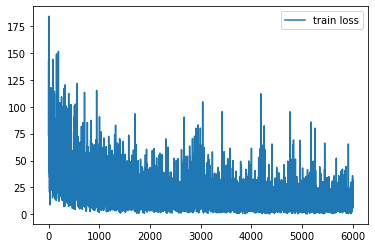

In [ ]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

In [ ]:
os.getcwd()

'/content/l5kit/examples'

In [ ]:
%cd

/root


In [ ]:
!ls

In [ ]:
%cd /tmp/

/tmp


In [ ]:
%cd /content/


/content


In [ ]:
!wget https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/prediction/v1.1/validate.tar

--2022-05-02 00:16:37--  https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/prediction/v1.1/validate.tar
Resolving lyft-l5-datasets-public.s3-us-west-2.amazonaws.com (lyft-l5-datasets-public.s3-us-west-2.amazonaws.com)... 52.218.237.9
Connecting to lyft-l5-datasets-public.s3-us-west-2.amazonaws.com (lyft-l5-datasets-public.s3-us-west-2.amazonaws.com)|52.218.237.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8804925440 (8.2G) [application/x-tar]
Saving to: ‘validate.tar’

validate.tar        100%[===================>]   8.20G  18.3MB/s    in 7m 42s  

2022-05-02 00:24:20 (18.2 MB/s) - ‘validate.tar’ saved [8804925440/8804925440]



In [ ]:
!wget https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/prediction/v1.1/sample.tar

--2022-05-01 07:31:12--  https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/prediction/v1.1/sample.tar
Resolving lyft-l5-datasets-public.s3-us-west-2.amazonaws.com (lyft-l5-datasets-public.s3-us-west-2.amazonaws.com)... 52.218.193.73
Connecting to lyft-l5-datasets-public.s3-us-west-2.amazonaws.com (lyft-l5-datasets-public.s3-us-west-2.amazonaws.com)|52.218.193.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53862400 (51M) [application/x-tar]
Saving to: ‘sample.tar’

sample.tar          100%[===================>]  51.37M  16.2MB/s    in 3.2s    

2022-05-01 07:31:16 (16.2 MB/s) - ‘sample.tar’ saved [53862400/53862400]



In [ ]:
torch.cuda.empty_cache()

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()

In [ ]:
import tensorflow as tf

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [ ]:
!tar xf /content/validate.tar -C /tmp/tmp.ghvlFac0hY/val

In [ ]:
# ===== GENERATE AND LOAD CHOPPED DATASET
num_frames_to_chop = 100
eval_cfg = cfg["val_data_loader"]
eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

starting pool...


16220/16220: : 16220it [23:08, 11.68it/s]


collecting results..
start report for /tmp/tmp.ghvlFac0hY/val/validate.zarr
{   'reject_th_AV_distance': 39973397,
    'reject_th_agent_filter_probability_threshold': 209417891,
    'reject_th_extent': 13277763,
    'reject_th_yaw': 767938,
    'th_agent_filter_probability_threshold': 0.5,
    'th_distance_av': 50,
    'th_extent_ratio': 1.1,
    'th_yaw_degree': 30,
    'total_agent_frames': 312617887,
    'total_reject': 263436989}


computing past/future table: 100%|██████████| 4/4 [00:18<00:00,  4.53s/it]


+-------------+-----------+----------+----------+---------+
| past/future |     0     |    10    |    30    |    50   |
+-------------+-----------+----------+----------+---------+
|      0      | 312617887 | 22457696 | 12608787 | 8267456 |
|      10     |  22457696 | 16294329 | 10088382 | 6925901 |
|      30     |  12608787 | 10088382 | 6925901  | 5067600 |
|      50     |  8267456  | 6925901  | 5067600  | 3801149 |
+-------------+-----------+----------+----------+---------+
end report for /tmp/tmp.ghvlFac0hY/val/validate.zarr


/usr/local/lib/python3.7/dist-packages/l5kit/data/zarr_utils.py:244: RuntimeWarning: zarr dataset path doesn't exist. Open will fail for this dataset!
  output_dataset = ChunkedDataset(output_zarr)
copying: 100%|██████████| 16220/16220 [05:52<00:00, 45.99it/s]
/usr/local/lib/python3.7/dist-packages/l5kit/evaluation/extract_ground_truth.py:52: RuntimeWarning: you're running with a custom agents_mask
  dataset = AgentDataset(cfg=cfg, zarr_dataset=zarr_dataset, rasterizer=rasterizer, agents_mask=agents_mask)
extracting GT: 100%|██████████| 94694/94694 [20:42<00:00, 76.18it/s]


In [ ]:
model

In [ ]:
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: you're running with a custom agents_mask
  


+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  1622000   | 125423254  |    11733321   |      45.06      |        100.00        |        77.33         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
ckpt = torch.load("/content/final_model.pth", map_location=device)


In [ ]:
ckpt.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

In [ ]:
model = resnet50(pretrained = True)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
model.load_state_dict(ckpt)

<All keys matched successfully>

In [ ]:
checkpoint = torch.load("/content/l5kit/examples/logs/run_20220501-040705/checkpoint_epoch900.pth", map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
# ==== EVAL LOOP
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
agent_ids = []

progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, ouputs = forward(data, model, device, criterion)
    
    # convert agent coordinates into world offsets
    agents_coords = ouputs.cpu().numpy()
    world_from_agents = data["world_from_agent"].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = transform_points(agents_coords, world_from_agents) - centroids[:, None, :2]
    
    future_coords_offsets_pd.append(np.stack(coords_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    

  0%|          | 0/7892 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 7892/7892 [27:43<00:00,  4.74it/s]


In [ ]:
pred_path = f"{gettempdir()}/pred.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

In [ ]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)


neg_multi_log_likelihood 918.7583097735494
time_displace [0.17470089 0.28681274 0.50202936 0.65717503 0.74968363 0.87155808
 0.98705557 1.11084352 1.24511669 1.39491471 1.53911031 1.61851919
 1.74523058 1.89195421 1.96841734 2.10488952 2.2423803  2.37799909
 2.50151405 2.62246054 2.71498066 2.84053817 2.96550974 3.08605762
 3.21264484 3.31635811 3.41204442 3.52181033 3.62269974 3.72841291
 3.84525653 3.94328055 4.04947047 4.13192863 4.2346281  4.3230254
 4.41475011 4.50598604 4.58758881 4.669788   4.73539007 4.82669626
 4.91646912 5.01180078 5.08917953 5.15438143 5.23152885 5.30609454
 5.39507611 5.47345895]


In [ ]:
model.eval()
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

    plt.imshow(im_ego)
    plt.show()